# Imbalanced data problems

In [2]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.datasets import make_circles, make_blobs, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler

SEED = 314159
TRAIN_TEST_SPLIT = 0.80

data_path = "/home/victor/Datasets/ml"

Рассмотрим набор данных о качестве вина на основе различных химических показателей. Есть всего 6 значений качества, поэтому задачу проще всего решать классификацией.

In [8]:
df = pd.read_csv(data_path+'/'+"winequality-red.csv", sep=",")

In [9]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Несбалансированные данные
Несбалансированные данные - это одна из наиболее распространенных проблем, с которой сталкиваются в машинном обучении. Они возникают, когда классы, которые мы пытаемся предсказать, представлены неравномерно. Другими словами, один класс имеет гораздо меньше примеров, чем другой, что создает дисбаланс в распределении данных.
Деревья решений очень уязвимы перед дисбалансом классов, так как используют вероятности в критериях разбиения.

**Задание**: Определите, сколько в датасете примеров хорошего вина (оценка 7 и выше) и плохого (3) в процентах от общего количества

In [10]:
df.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

**Задание**: Создайте новый признак "good_quality", чтобы выделить именно хорошее вино

In [11]:
df['good_quality'] = df['quality'] > 6

In [13]:
df.good_quality.value_counts()

good_quality
False    1382
True      217
Name: count, dtype: int64

In [12]:
y_binarized = (df['quality'] > 6).astype(int)

In [14]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
_, _, y_train_b, y_test_b = train_test_split(X, y_binarized, test_size=0.2, random_state=SEED)

In [15]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
print("Train score is: ", model.score(X_train, y_train))
print("Test score is: ", model.score(X_test, y_test))

Train score is:  1.0
Test score is:  0.715625


In [16]:
model_b = DecisionTreeClassifier(random_state=0)
model_b.fit(X_train, y_train_b)
print("Train score is: ", model_b.score(X_train, y_train_b))
print("Test score is: ", model_b.score(X_test, y_test_b))

Train score is:  1.0
Test score is:  1.0


### Метрики
Так как данные несбалансированные, уместно ли использовать встроенное значение score для оценки модели? На самом деле, и да и нет, так как score возвращает усредненную точность по классам. Однако еще более информатиными будут F1-мера и другие более подробные оценки.
Формула Precision:
\begin{equation}
\text{Precision} = \frac{\text{TP}}{ \text{TP} + \text{FP} }
\end{equation}
Precision наиболее полезна, если цена FP велика. Примеры такой задачи - детекция спама. В случае, если полезное письмо попадет в спам, юзер может потерять важную информацию, что нежелательно.
Формула Recall:
\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}
Recall наиболее полезна, если цена FN велика. Она поможет, если нам необходимо найти всех больных пациентов, определить фрод и т.д.
Вопрос: что отражают две эти метрики?


Формула F1-метрики:
\begin{equation}
\text{F1} = \frac{2 * \text{TP}}{2 * \text{TP} + \text{FP} + \text{FN}}
\end{equation}
F1-метрика может быть выведена из precision и recall и позволяет найти баланс между ними. 

**Задание**: определите, как f1 выводится из precision и recall.

Существует и болеее общая оценка - $F_\beta$. Она позволяет получить взвешенное среднее между precision и recall. Ее формулу дадим на занятии. Наиболее популярные параметры - 2 и 0.5.
Тут тоже есть особенности. Метрики бывают нескольких видов, в зависимости от того, как учитываются разные классы:
- микро - метрики считаются глобально сразу по всем классам.
- макро - вначале считаются для каждого класса, потом берется среднее
- взвешенные по классам - вначале считаются для каждого класса, потом берется среднее, взвешенное по поддержке

Вопрос: какой способ вычисления лучше всего выбрать при дисбалансе классов? Покажите на примере.

In [ ]:
# It's time to write something on whiteboard

In [19]:
from sklearn.metrics import f1_score

print("Train f1-score is: ", f1_score(y_train, model.predict(X_train), average="micro"))
print("Test f1-score is: ", f1_score(y_test, model.predict(X_test), average="macro"))

Train f1-score is:  1.0
Test f1-score is:  0.4676044863032091


In [18]:
print("Train f1-score (binary) is: ", f1_score(y_train_b, model_b.predict(X_train), average="micro"))
print("Test f1-score  (binary) is: ", f1_score(y_test_b, model_b.predict(X_test), average="micro"))

Train f1-score (binary) is:  1.0
Test f1-score  (binary) is:  1.0


In [ ]:
# get macro metrics for basic prediction

In [ ]:
# get macro metrics for binarized prediction

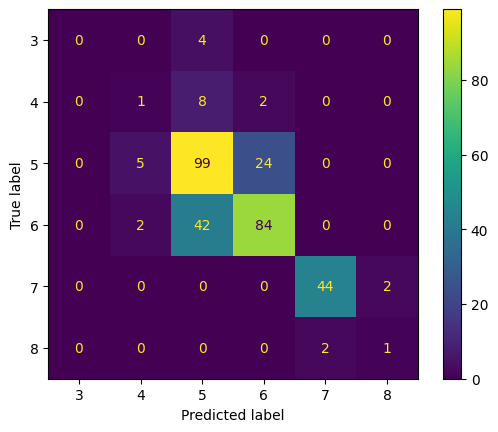

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

Давайте руками рассмотрим, как оценивается точность и почему нам сложно получить адекватную оценку при сильном дисбалансе.

In [21]:
metrics_df = pd.DataFrame(columns=['label', 'TP', 'TN', 'FP', 'FN', 'support', 'accuracy', 'precision', 'recall'])

In [22]:
classes = np.unique(y_train)
classes.sort()
print(classes)

[3 4 5 6 7 8]


In [23]:
y_pred = model.predict(X_test)

**Задание**: Закончите код для рассчета метрик по классам.

In [ ]:
for class_id in classes:
    class_stats = {}
    gt = X_test.loc[y_test==class_id]
    class_stats["support"] = len(gt)
    ########### YOUR CODE
    # get model predictions
    # calculate number of TP, FP, TN and FN for this class using filtering
    # Use provided metrics to calculate accuracy, precision and recall    
    ########### YOUR CODE
    metrics_df = pd.concat([metrics_df, pd.DataFrame(class_stats, index=[0])], ignore_index=True)

In [ ]:
metrics_df

**Задание**: Посчитайте макро-метрики. 

**Задание со звездочкой**: Посчитайте микро-метрики. 

## Imbalanced learning

Как заставить модель учиться так, чтобы учитывать все классы? Самое простое - задать вес класса.

Вопрос: Какие есть хорошие способы это сделать?

In [ ]:
class_weights =  # your code: set the list of weights of your choice
model = DecisionTreeClassifier(class_weight={classes[i]: w for i, w in enumerate(class_weights)}, random_state=0)
model.fit(X_train, y_train)
print("Train score is: ", model.score(X_train, y_train))
print("Test score is: ", model.score(X_test, y_test))

In [ ]:
class_weights

In [ ]:
# make the classifier with weights for binarized case too.  Output it's internal scores for train and test.

In [ ]:
# output train/test micro and macro f1 scores for weighted and unweighted trees (all classes)

In [ ]:
# output train/test micro and macro f1 scores for weighted and unweighted trees (binarized classes)

Выведем, как изменились предсказания модели.

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [ ]:
# create new dataframe with metrics

Также посмотрим, насколько чувствительна к дисбалансу другая модель - LogisticRegression

In [ ]:
logreg = # make pipeline of Scaler and Logreg
logreg.fit(X_train, y_train)
print("Naive train score is: ", logreg.score(X_train, y_train))
print("Naive test score is: ", logreg.score(X_test, y_test))
print("Classes", logreg.classes_)

In [ ]:
logreg = # make pipeline of Scaler and Logreg with class weights
logreg.fit(X_train, y_train)
print("Balanced train score is: ", logreg.score(X_train, y_train))
print("Balanced test score is: ", logreg.score(X_test, y_test))

То же самое можно сделать с использованием итеративного линейного классификатора. Используем для этого SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
logreg = # make pipeline of Scaler and SGDClassifier without class weights
logreg.fit(X_train, y_train)
print("Naive train score is: ", logreg.score(X_train, y_train))
print("Naive test score is: ", logreg.score(X_test, y_test))
print("Naive test f1-score is: ", f1_score(y_test, y_pred=logreg.predict(X_test), average="macro"))

In [ ]:
logreg = # make pipeline of Scaler and SGDClassifier with class weights
logreg.fit(X_train, y_train)
print("Balanced train score is: ", logreg.score(X_train, y_train))
print("Balanced test score is: ", logreg.score(X_test, y_test))
print("Balanced test f1-score is: ", f1_score(y_test, y_pred=logreg.predict(X_test), average="macro"))

**Задание**: Обучите более сильный классификатор (RF, GB). Постройте confusion matrix, выведите скоры для него с балансировкой и без. Ответьте на вопрос, как соотносится чувствительность более сильных классификаторов к дисбалансу с более слабыми.

------

Как видно, балансировка не всегда одинаково полезна. Однако мы можем попробовать воспользоваться дополнительными методами для обучения нашего дерева. Это будет андер- и оверсемплинг (балансировка датасета). Самое простое - взять только небольшую, но сбалансированную часть обучающих данных для непосредственного обучения. Однако, для нашего случая это плохо подходит, так как данных довольно мало.

Еще раз вспомним, какие предсказания давало дерево решений для нашего набора

In [ ]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
print("Train score is: ", model.score(X_train, y_train))
print("Test score is: ", model.score(X_test, y_test))
print("Test f1-score is: ", f1_score(y_test, y_pred=model.predict(X_test), average="macro"))

# Оверсемплинг

Для начала проведем простейший оверсемплинг, выбирая семплы из минорного класса с заменой до достижения баланса:

In [24]:
def print_counts(y) -> None:
    unique, counts = np.unique(y, return_counts=True)
    print("\n".join([f"{u}: {c}" for u, c in zip(unique, counts)]))

In [25]:
X_gen, y_gen = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.02, 0.05, 0.94],
                           class_sep=0.8, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_gen) # train test split


In [26]:
ros = RandomOverSampler(random_state=SEED, ) # choose your parameters
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)
print("Train score is: ", model.score(X_res, y_res))
print("Test score is: ", model.score(X_test, y_test))
print("Test f1-score is: ", f1_score(y_test, y_pred=model.predict(X_test), average="macro"))
print_counts(y_res)

NameError: name 'X_res' is not defined

In [ ]:
ros = RandomOverSampler(random_state=SEED, ) # choose your parameters
X_res, y_res = ros.fit_resample(X_train, y_train)
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_res, y_res)
print("Train score is: ", model.score(X_res, y_res))
print("Test score is: ", model.score(X_test, y_test))
print("Test f1-score is: ", f1_score(y_test, y_pred=model.predict(X_test), average="macro"))
print_counts(y_res)

### SMOTE (Synthetic Minority Oversampling Technique):
SMOTE позволяет расширить выборку, построив синтетические примеры на основе уже существующих. Это еще один вариант решения «проблем классового дисбаланса».

Общая схема SMOTE:
1) Для создания нового семпла используют пару признаков «соседних» примеров a  и b из миноритарного класса. Их находят, используя алгоритм ближайшего соседа KNN. В данном случае необходимо и достаточно для семпла a получить набор из k соседей, из которого в дальнейшем будет случайно выбран семпл b.
2) Для создания нового семпла находят разность $d=X_b–X_a$, где $X_a,X_b$ – векторы признаков «соседних» примеров a  и b из миноритарного класса.
3) Далее из $d$ путем его умножения на случайное число в интервале (0,1)  получают $d'$.
4) Вектор признаков нового примера вычисляется путем сложения Xa и $d'$.

Вопрос: сколько соседей выбирать? И сколько соседей стоит использовать для каждой узловой точки?


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=SEED) # choose your parameters
X_res, y_res = smote.fit_resample(X_train, y_train)
print_counts(y_res)

In [ ]:
smote = SMOTE(random_state=SEED) # choose your parameters
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_res, y_res)
print("Train score is: ", model.score(X_res, y_res))
print("Test score is: ", model.score(X_test, y_test))
print("Test f1-score is: ", f1_score(y_test, y_pred=model.predict(X_test), average="macro"))

In [ ]:
smote = SMOTE(random_state=SEED) # choose your parameters
X_res, y_res = smote.fit_resample(X_train, y_train)
print_counts(y_res)

In [ ]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_res, y_res)
print("Train score is: ", model.score(X_res, y_res))
print("Test score is: ", model.score(X_test, y_test))
print("Test f1-score is: ", f1_score(y_test, y_pred=model.predict(X_test), average="macro"))

Также мы можем получить более подробный отчет по точности модели.

In [ ]:
from imblearn.metrics import classification_report_imbalanced

In [ ]:
print(classification_report_imbalanced(y_test, model.predict(X_test)))

Рассмотрим также то, как разные алгоритмы принимают решение.

In [ ]:
ros = RandomOverSampler(random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [ ]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)

In [ ]:
X_train

In [ ]:
# Choosing the first 2 columns for the plot

def get_decision_boundary(X_train, y_train, features, ax=None, model="logistic"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    # Creating and fitting the tree classifier
    if model == "logistic":
        classifier = LogisticRegression() # your code: 
    else:
        classifier = RandomForest() # your code: choose another one
    # your code: fit model
    classifier.fit(X_train, y_train)
    # Plotting the tree boundaries
    plot_decision_function(X_train, y_train, classifier, ax)

    # Plotting the data points
    ax.scatter(X_train[:, 0], X_train[:, 1], alpha=0.8, c=y_train, edgecolor='k')
    plt.title(f"Decision surface for {classifier.__class__.__name__} on {features[0]} and {features[1]}")
    plt.show()


In [ ]:
y_train.shape

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
get_decision_boundary(X_train, y_train, features = ['x1', 'x2' ], ax=ax)

In [ ]:

get_decision_boundary(X_resampled, y_resampled, features = ['x1', 'x2' ])

In [ ]:
smote = SMOTE(random_state=SEED, k_neighbors=4)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
get_decision_boundary(X_resampled, y_resampled, features = ['x1', 'x2' ])

Введем еще один метод оверсемплинга - AdaSYN (Adaptive Synthetic). Этот алгоритм, в отличие от ресэмплинга и SMOTE позволяет сгенерировать более "сложные" примеры.
Этот алгоритм работает следующим образом:
1) Рассчитывается отношение миноритарного и мажоритарного класса: $d = m_s / m_l $
2) Определяется, сколько элементов необходимо нагенерировать: $G = (m_l - m_s) * \beta $. $\beta $ - параметр балансировки
3) Для каждого семпла из миноритарного класса находятся k соседей. После чего ему присваивается вес $r_i = num_major_neighbours / k $.
4) $r_i$ нормализуются так, чтобы их сумма равнялсь 1: $ {r_i}' =  \frac {r_i} {\sum{r_j}$
5) Для каждого семпла определяется число сгененрированных примеров.  $G_i = G * {r_i}' $. Вопрос: в каких областях будет генерироваться больше примеров?
6) Далее для каждого примера и его соседей генерируется синтетический пример, как в SMOTE. Также может быть использована добавка белого шума.

Вопрос: какие минусы у SMOTE и AdaSYN по отношению друг к другу?

In [ ]:
from imblearn.over_sampling import ADASYN
smote = ADASYN(random_state=SEED) # your parameters
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
get_decision_boundary(X_resampled, y_resampled, features = ['x1', 'x2' ])

На графике сразу видно, когда AdaSYN  может помешать хорошей генерации. Как видно, так как AdaSYN концентрирует сгенерированные примеры у границ классов, тогда как SMOTE может "соединять" и примеры в центральной части класса, то он может быть более удачным методом. К тому же, сущестуют различные вариации SNOTE, которые могут давать хороший рещультат в такой постановке.

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(random_state=SEED) # your parameters
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
get_decision_boundary(X_resampled, y_resampled, features = ['x1', 'x2' ])

Вопрос: какие можно еще придумать более "умные" варианты оверсемплинга на основе CMOTE?

**Задание:** Примените разные алгоритмы на данных с вином. Помогает ли оверсемплинг для работы слабых и сильных моделей? 

## Уменьшение выборки (андерсемплинг)

### Prototype generation
Методы Prototype generation (создания прототипов) позволяют сократить количество объектов в целевых классах, но остальные объекты генерируются, а не выбираются, из исходного набора.
ClusterCentroids использует для этого KMeans.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
sampler = ClusterCentroids(random_state=SEED, estimator=KMeans())# your parameters)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
get_decision_boundary(X_resampled, y_resampled, features = ['x1', 'x2' ])

In [ ]:
from imblearn.under_sampling import ClusterCentroids
sampler = ClusterCentroids(random_state=SEED, estimator=KMeans())# your parameters)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
get_decision_boundary(X_resampled, y_resampled, features = ['x1', 'x2' ])

### Prototype selection
Алгоритмы Prototype selection (выбора прототипов) можно разделить на две группы: (i) методы контролируемой недостаточной выборки и (ii) методы очистки недостаточной выборки.

Эти методы сокращают количество примеров в мажоритарных классах до произвольного размера, указанного пользователем. Обычно они сводят количество наблюдений к размеру миноритарного класса(ов).
К ним относятся: Random UnderSampling, NearMiss.
Prototype selection «очищают» пространство признаков, удаляя либо «зашумленные», либо «слишком легко классифицируемые» наблюдения, в зависимости от метода. Окончательное количество наблюдений в каждом классе зависит от метода очистки и не может быть указано пользователем.
К ним относится, например, метод связей Томека.


Наиболее простой метод - RandomUnderSampler - просто выкидывает семплы случайным образом.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
get_decision_boundary(X_resampled, y_resampled, features = ['x1', 'x2' ])

Попробуйте реализовать такой семплер вручную:

In [ ]:
# your code

NearMiss добавляет некоторые эвристики для выбора семплов. Так, он может выбирать для удаления примеры, ближайшие к миноритарном классу, примеры, среднее расстояние у которых до наиболее дальних примеров из миноритарного класса наименьшее.

In [ ]:
# you can add some figures with nearmiss undersampling (use imblearn)

Связь Томека существует, когда два примера из разных классов являются ближайшими соседями друг к другу. Алгоритм связей Томека детектирует такие связи и удаляет пример из мажоритарного класса. Основная идея заключается в том, что связи Томека зашумлены или наблюдения трудно классифицировать, и поэтому они не помогут алгоритму найти подходящую границу разделения.


In [ ]:
# your сode (use imblearn)

Edited nearest neighbours - для примеров из миноритарного класса находит k ближайших соседей и удаляет все семплы из мажоритарных классов, попавшие в эту окрестность.

In [ ]:
# your code (use imblearn)